In [1]:
!pip install torch torch_geometric -q

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import KarateClub
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
dataset = KarateClub()
# O dataset contém somente um gráfico
data = dataset[0]

In [4]:
help(dataset)

Help on KarateClub in module torch_geometric.datasets.karate object:

class KarateClub(torch_geometric.data.in_memory_dataset.InMemoryDataset)
 |  KarateClub(transform: Optional[Callable] = None)
 |  
 |  Zachary's karate club network from the `"An Information Flow Model for
 |  Conflict and Fission in Small Groups"
 |  <http://www1.ind.ku.dk/complexLearning/zachary1977.pdf>`_ paper, containing
 |  34 nodes, connected by 156 (undirected and unweighted) edges.
 |  Every node is labeled by one of four classes obtained via modularity-based
 |  clustering, following the `"Semi-supervised Classification with Graph
 |  Convolutional Networks" <https://arxiv.org/abs/1609.02907>`_ paper.
 |  Training is based on a single labeled example per class, *i.e.* a total
 |  number of 4 labeled nodes.
 |  
 |  Args:
 |      transform (callable, optional): A function/transform that takes in an
 |          :obj:`torch_geometric.data.Data` object and returns a transformed
 |          version. The data obj

In [5]:
dataset.num_node_features

34

In [6]:
data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [7]:
data.x[:5]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [8]:
import numpy as np

np.argmax(data.x, axis=0)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [9]:
data.edge_index.t().tolist()[:13]

[[0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [0, 5],
 [0, 6],
 [0, 7],
 [0, 8],
 [0, 10],
 [0, 11],
 [0, 12],
 [0, 13],
 [0, 17]]

In [10]:
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

In [11]:
data.train_mask

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])

In [12]:
# Verifica o número de nós no grafo
num_nodes = data.num_nodes

# Criamos máscaras de treinamento e teste
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Para o exemplo do Karate Club, vamos usar um conjunto simples:
# Os nós de 0 a 33 para o treinamento (primeiros 34 nós)
# Os nós de 34 até o final para o teste (últimos nós)
data.train_mask[:int(num_nodes * 0.5)] = True
data.test_mask[int(num_nodes * 0.5):] = True

# Verifica se as máscaras foram configuradas corretamente
print(f'Treino: {int(data.train_mask.sum())} nós, Teste: {int(data.test_mask.sum())} nós')

Treino: 17 nós, Teste: 17 nós


In [13]:
data.train_mask

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False])

In [14]:
data.test_mask

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True])

In [15]:
def plot_graph(data):
    G = nx.Graph()
    G.add_edges_from(data.edge_index.t().tolist())
    plt.figure(figsize=(8, 8))
    colors = data.y.numpy()
    nx.draw(G, node_color=colors, with_labels=True, cmap=plt.get_cmap('Set3'))
    plt.show()

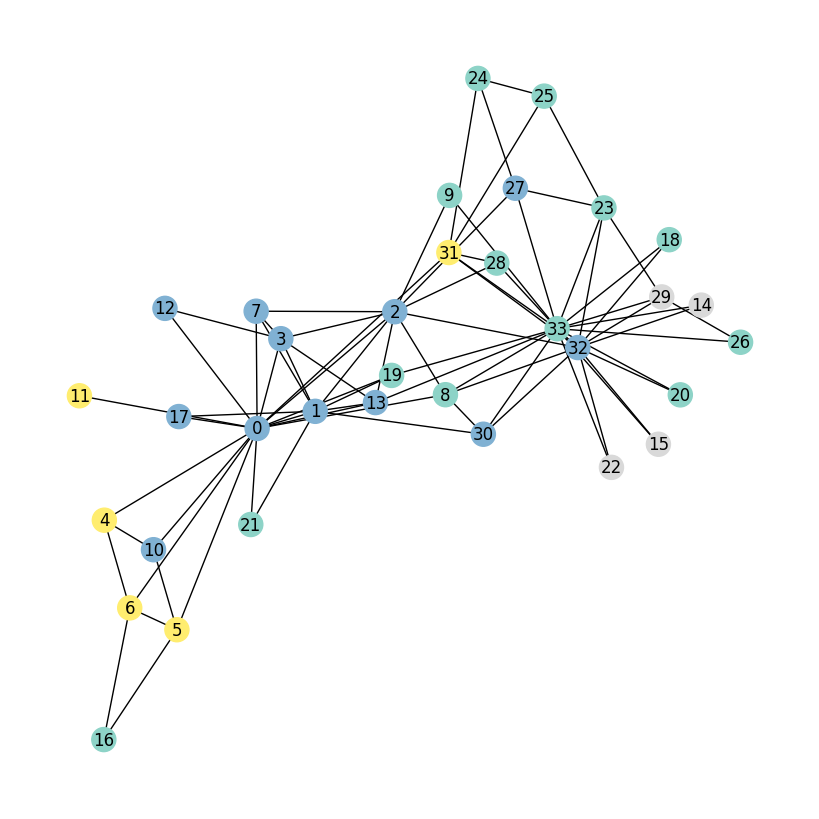

In [16]:
plot_graph(data)

Os nós de 0 a 16 são de treino e de 17 a 33 são de treino

In [17]:
# Arquitetura da GNN:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [18]:
model = GCN()

In [19]:
# Otimizador e função de perda:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

In [30]:
# Ciclo de treinamento:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Função de Avaliação
def test():
    model.eval()  # Coloca o modelo em modo de avaliação
    with torch.no_grad():  # Desativa a autograd (economiza memória e tempo)
        out = model(data)  # Computa as predições do modelo
    pred = out.argmax(dim=1)  # Encontra a classe predita com maior probabilidade
    # print predição e classe real
    print(f'Predição: {pred[data.test_mask]}')
    print(f'Classe real: {data.y[data.test_mask]}')
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()  # Conta os acertos
    acc = correct.float() / data.test_mask.sum().float()  # Calcula a acurácia
    return acc.item()  # Retorna a acurácia como valor escalar

In [31]:
# Treinamento e avaliação:
for epoch in range(200):
    loss = train()
    if epoch % 20 == 0:
        acc = test()
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

# Teste final:
final_acc = test()
print(f'Final Test Accuracy: {final_acc:.4f}')

Predição: tensor([1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0])
Classe real: tensor([1, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
Epoch: 0, Loss: 0.0074, Test Accuracy: 0.7059
Predição: tensor([1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0])
Classe real: tensor([1, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
Epoch: 20, Loss: 0.0074, Test Accuracy: 0.7059
Predição: tensor([1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0])
Classe real: tensor([1, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
Epoch: 40, Loss: 0.0074, Test Accuracy: 0.7059
Predição: tensor([1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0])
Classe real: tensor([1, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
Epoch: 60, Loss: 0.0074, Test Accuracy: 0.7059
Predição: tensor([1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0])
Classe real: tensor([1, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
Epoch: 80, Loss: 0.0074, Test Accuracy: 0.7059
Predição: tensor([1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 